<a href="https://colab.research.google.com/github/Graviton12/CS-430-Group-Project/blob/main/olmstead_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [126]:
data = pd.read_csv('/content/drive/MyDrive/CS430/olmstead_combined.csv')

In [127]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,Unnamed: 17
0,92.98,"Walnut, maple, mulberry, locust",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,NaN
1,98.18,"Cherry, hackberry, maple",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,NaN
2,97.40,"Oak, basswood, maple",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,NaN
3,93.24,"Locust, walnut, sycamore",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,NaN
4,87.00,"Oak, maple, locust",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN


In [128]:
#drop last column
data = data.iloc[:, :-1]

In [129]:
numeric_data = data.select_dtypes(include=np.number)

# Create and apply the imputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(numeric_data)


# Update the original DataFrame with imputed values
data[numeric_data.columns] = imputed_data

In [130]:
# drop the empty canopy rows
data = data.dropna(subset=['canopy'])

In [131]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }
    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
data['canopy'] = data['canopy'].apply(clean_canopy_as_list_lowercase)


In [132]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,92.98,"[walnut, maple mulberry, locust]",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,98.18,"[cherry, hackberry, maple]",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,97.40,"[oak, basswood, maple]",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,93.24,"[locust, walnut, sycamore]",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,87.00,"[oak, maple locust]",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [133]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_data = data.explode('canopy')

# One-hot encode using pd.crosstab
canopy_crosstab = pd.crosstab(index=exploded_data.index, columns=exploded_data['canopy'])

# Merge the one-hot encoded data back with the original DataFrame
olmstead_encoded = pd.concat([data.drop(columns=['canopy']), canopy_crosstab], axis=1)

In [134]:
olmstead_encoded.tail()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
306,81.28,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
307,68.02,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
308,74.78,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
309,77.64,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
310,84.14,2.0,1.0,1.0,4.0,4.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
scaler = StandardScaler()
olmstead_scaled = scaler.fit_transform(olmstead_encoded)

In [136]:
olmstead_scaled = pd.DataFrame(olmstead_scaled, columns=olmstead_encoded.columns)
olmstead_scaled.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
0,0.297916,-0.247319,1.601969,-0.332236,1.264736,-0.232642,3.888390,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
1,0.736418,2.199558,-0.538593,1.648403,-0.251969,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
2,0.670642,1.383933,-0.538593,-0.332236,-1.010321,-0.232642,-0.510883,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
3,0.319841,-0.247319,0.531688,-0.332236,2.023088,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
4,-0.206361,-1.062944,-0.538593,-0.332236,0.506384,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796


In [137]:
# creating a kmeans pipeline olmstead_encoded
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=6, random_state=42))
])

# Fit and get the cluster labels
kmeans_labels = kmeans_pipeline.named_steps['kmeans'].fit_predict(olmstead_scaled)


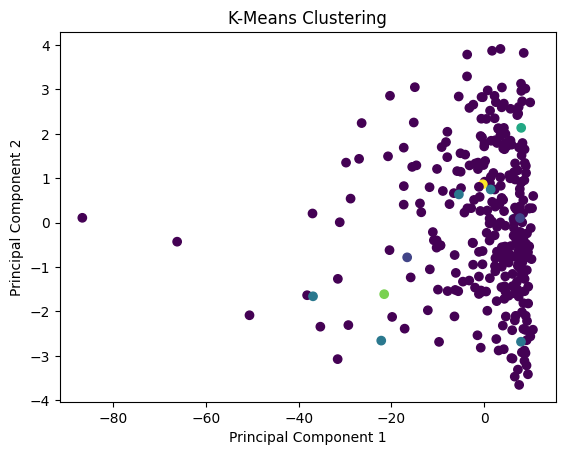

In [138]:
#visual using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(olmstead_encoded)

# Now use kmeans_labels (which holds the cluster assignments) for coloring the scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.show()

In [139]:
#silhoutte score
kmeans_score = silhouette_score(olmstead_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means: {kmeans_score}")

Silhouette Score for K-Means: -0.011628587733285822


In [140]:
#adding a column for cluster into the data
olmstead_encoded['cluster'] = kmeans_labels

In [141]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
#random forest regressor for invasive species sum
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [144]:
#creating a column 'invasive_species_sum' based on summing columns 2-16
olmstead_encoded['invasive_species_sum'] = olmstead_encoded.iloc[:, 2:17].sum(axis=1)


In [145]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster,invasive_species_sum
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,19.0
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,11.0
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,18.0
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0


In [148]:
#splitting the data
X = olmstead_encoded.drop(['cluster', 'invasive_species_sum'], axis=1)
y = olmstead_encoded['invasive_species_sum']

In [149]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
#random forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestRegressor(random_state=42))
])

In [152]:
#fitting pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestRegressor(random_state=42))])

In [153]:
#ypred
y_pred = rf_pipeline.predict(X_test)

In [154]:
#evaluating model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5.8034962586966286
R-squared: 0.6961844907306252


In [156]:
#evaluating for overfitting
train_score = rf_pipeline.score(X_train, y_train)
test_score = rf_pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.970457024268448
Testing Score: 0.6961844907306252
